# Badanie aktywów giełdowych z wykorzystaniem modelu LPPL, algorytmu drzew decyzyjnych XGBoost oraz analizy sentymentu

Celem niniejszej pracy było stworzenie narzędzia, które może służyć jako pomoc w procesie dokonywania decyzji inwestycyjnych.  <br>

Co do zastosowanych narzędzi, zdecydowano się na wykorzystanie modelu LPPL, który pozwala określić szybszy niż eksponencjalny wzrost lub też spadek wartości danego aktywa. <br>
Następnie, przedstawione zostały wyniki zastosowania algorytmu uczenia maszynowego XGBoost, na podstawie którego sporządzone zostały predykcje kształtowania się ceny wybranego obiektu. <br>
W ostatnim kroku sporządzona została analiza sentymentu, ażeby zmierzyć nastroje rynkowe, jakie panowały wśród użytkowników portalu Reddit a propos danego aktywa. <br>

Jako analizowanego obiektu zdecydowano się użyć otwartego funduszu inwestycyjnego ETF o nazwie: BlackRock iShares Global Clean Energy UCITS ETF USD (IQQH.DE), który odzwierciedla wartość rynku energii odnawialnej, aczkolwiek przygotowany kod z powodzeniem może również służyć do analizy innych aktywów, do których jednak niezbędne jest wybranie odpowiedniego okresu badania, a także adekwatnych słów kluczowych (w kontekście danych z Google Trends i Reddit). <br>

Oczywiście praca ta stanowi jedynie wycinek możliwości, jakie oferują analizy techniczna i sentymentu. Ponadto w przypadku dokonywania decyzji inwestycyjnych nie bez znaczenia pozostaje również analiza fundamentalna. 

# Plan pracy

1. Pobranie bibliotek
2. Pobranie analizowanej zmiennej wraz z regresorami
3. Znajdowanie bąbli spekulacyjnyjnych za pomocą modelu LPPL 
4. XGBoost - algorytm oparty na uczeniu maszynowym
5. Analiza sentymentu - Reddit

## 1. Pobranie bibliotek

In [ ]:
pip install -U lppls

In [ ]:
pip install xarray

In [ ]:
pip install pytrends

In [ ]:
pip install praw

In [ ]:
from urllib.request import urlretrieve
from datetime import datetime
import pandas as pd
from lppls import lppls, data_loader
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from pytrends.request import TrendReq
from pytrends import dailydata
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from IPython import display
import math
from pprint import pprint
import nltk
import seaborn as sns
import praw
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import matplotlib.pyplot as plt
import nltk
nltk.downloader.download('vader_lexicon')
nltk.downloader.download('stopwords')

%matplotlib inline

## 2. Pobranie analizowanej zmiennej wraz z regresorami

##### Wybieramy obiekt do analizy wraz z rodzajem danych oraz okres w jakim prowadzimy analizę
ticker - nazwa aktywa <br>
interval - d - daily, w - weekly, m - monthly, q - quarterly, and y - yearly. <br>
number_of_days - okres w jakim przeprowadzamy analizę (liczony od dzisiaj)  

In [6]:
# Analizowany obiekt

ticker='IQQH.DE'
interval='d'
number_of_days=365

url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
csv_file = ticker + '.csv'
urlretrieve(url, csv_file)

data = (pd.read_csv(csv_file, index_col=False, parse_dates=['Date'],
            date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'), usecols=['Date', 'Close'])).tail(number_of_days)

data = data.rename({'Date': 'date', 'Close': 'close'}, axis=1)


#### Prezentacja graficzna, średnia oraz mediana.

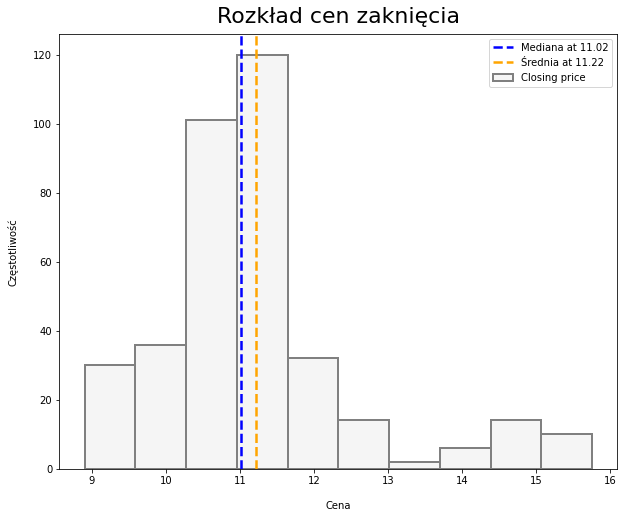

In [7]:
# Histogram cen zamknięcia

data["close"].plot(kind='hist', figsize=(10, 8), linewidth=2, color='whitesmoke', edgecolor='gray', label = "Closing price")
plt.xlabel("Cena", labelpad=15)
plt.ylabel("Częstotliwość", labelpad=15)
plt.title("Rozkład cen zaknięcia", y=1.012, fontsize=22)

measurements = [round(data["close"].median(), 2), round(data["close"].mean(), 2)]
names = ["Mediana", "Średnia"]
colors = ['blue', 'orange']

for measurement, name, color in zip(measurements, names, colors):
    plt.axvline(x=measurement, linestyle='--', linewidth=2.5, label='{0} at {1}'.format(name, measurement), c=color)
plt.legend();

<Figure size 720x576 with 0 Axes>

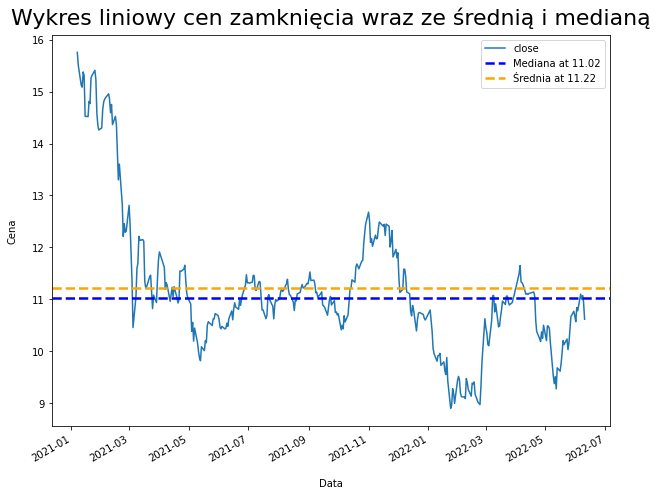

In [8]:
# Wykres liniowy cen zamknięcia

x1 = 'date'
y1 = "close"
plt.figure(figsize=(10, 8))
data.plot(kind='line',x=x1,y=y1, figsize=(10,8))

measurements = [round(data["close"].median(), 2), round(data["close"].mean(), 2)]
names = ["Mediana", "Średnia"]
colors = ['blue', 'orange']

for measurement, name, color in zip(measurements, names, colors):
    plt.axhline(y=measurement, linestyle='--', linewidth=2.5, label='{0} at {1}'.format(name, measurement), c=color)
    
plt.title("Wykres liniowy cen zamknięcia wraz ze średnią i medianą", y=1.012, fontsize=22)
plt.xlabel("Data", labelpad=15)
plt.ylabel("Cena", labelpad=15)
plt.legend();

##### Pobieram pozostałe regresory - w tym wypadku: cenę złota, indeks Nasdaq oraz popularność w trendach Google

##### Złoto

In [9]:
# Określam specyfikację (number_of days ustalony przy pobieraniu zmiennej objaśnianej)

ticker='XAUUSD'
interval='d'

url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
csv_file = ticker + '.csv'
urlretrieve(url, csv_file)

data_gold = (pd.read_csv(csv_file, index_col=False, parse_dates=['Date'],
            date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'), usecols=['Date', 'Close'])).tail(number_of_days)

data_gold = data_gold.rename({'Date': 'date', 'Close': 'close_gold'}, axis=1)


data_gold=data_gold.tail(number_of_days)

In [10]:
# Doklejam zbiór
data=data.merge(data_gold, on='date', how='left')

##### Nasdaq

In [11]:
# Określam specyfikację (number_of days ustalony przy pobieraniu zmiennej objaśnianej)
ticker='^NDQ'
interval='d'

url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
csv_file = ticker + '.csv'
urlretrieve(url, csv_file)

data_ndq = (pd.read_csv(csv_file, index_col=False, parse_dates=['Date'],
            date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d'), usecols=['Date', 'Close'])).tail(number_of_days)

data_ndq = data_ndq.rename({'Date': 'date', 'Close': 'close_nasdaq'}, axis=1)


data_ndq=data_ndq.tail(number_of_days)

In [12]:
# Doklejam zbiór
data=data.merge(data_ndq, on='date', how='left')

##### Google Trends

In [13]:
pytrends = TrendReq(hl='en-US', tz=360)

In [14]:
# Definiuję funkcje do przeprowadzenia importu z Google Trends
def collect_trend_score(keyword):
    pytrend = TrendReq() 
    pytrend.build_payload(kw_list=[keyword])
    df = pytrend.interest_over_time()
    return df

def resample_trend_score_df(df, keyword):
    trends = df[keyword].resample('D', convention = 'start').pad()
    trends = pd.DataFrame(trends)
    trends.rename(columns = {keyword:key}, inplace = True)
    return trends

In [15]:
# Definiuje okres
time_f=(str(data['date'].iloc[0])[0:10:1] + " " + str(datetime.today())[0:10:1])

In [16]:
# Definiuję słowo kluczowe
key='clean energy'

In [17]:
# Import danych
data_gt=collect_trend_score(key)
data_gt=resample_trend_score_df(data_gt, key)

In [18]:
# Doklejam zbiór
data=data.merge(data_gt, on='date', how='left')

## 3. Znajdowanie bąbli spekulacyjnyjnych za pomocą modelu LPPL 

### LPPL teoretycznie

Model LPPL jest modelem jednorównaniowym, gdzie zmienną modelowaną jest wartość oczekiwana zlogarytmowanej ceny danego aktywa w okresie t. Wystąpienie bańki jest definiowane jako istnienie, szybszego niż wykładniczy, wzrostu/spadku ceny danego aktywa, gdzie obecne zwroty stanowią do potencjalnych inwestorów/spekulantów niezmącony sygnał, że w przyszłym okresie zwroty z tego aktywa będą jeszcze wyższe/niższe. Model LPPL przedstawia się następująco:

#### E[ln(p(t)]=A+B〖(t_c-t)〗^m+C〖(t_c-t)〗^m*cos(ω*ln(t_c-t)-θ)

gdzie:

E[ln(p(t)] – spodziewany logarytm ceny aktywa w momencie pęknięcia bańki <br>
t_c – moment pęknięcia bańki <br>
A – spodziewany logarytm ceny aktywa w momencie szczytu, gdy pęknięcie bański następuje w czasie tc <br>
B – amplituda wykładniczego wzrostu ceny <br>
C – amplituda log-okresowych oscylacji <br>
m – stopień wzrostu wykładniczego <br>
ω – współczynnik skalowania czasowej hierarchii oscylacji <br>
θ – czasowa skala oscylacji <br>

Model ten zawiera trzy główne komponenty, które mogą sugerować istnienie bąbla na danym aktywie. A+B〖(t_c-t)〗^m odpowiada za hiperboliczne prawo potęgowe (dla m<1 zbliżanie się okresu do punktu krytycznego tc sprawia, że cena w sposób asymptotyczny zbiega do nieskończoności. Moduł C〖(t_c-t)〗^m odzwierciedla amplitudę oscylacji ceny. Część cos(ω*ln(t_c-t)-θ) jest odpowiedzialna za częstotliwość oscylacji ceny – dąży do nieskończoności w przypadku wejścia w okres krytyczny tc. 


In [19]:
# Konwertuję czas do formatu ordinal
time = [pd.Timestamp.toordinal(t1) for t1 in data['date']]

In [20]:
# Tworzę listę obserwacji
price = np.log(data['close'].values)

In [21]:
# Tworzę wektor obserwacji (konieczny od modelu LPPLS)
observations = np.array([time, price])

In [22]:
# Określam maksymalną liczbę wyszukiwań do momentu przerwania
# Literatura sugeruje 25
MAX_SEARCHES = 25

In [23]:
# Tworzę model LPPL
lppls_model = lppls.LPPLS(observations=observations)

In [24]:
# Dopasowuję model do danych i zwracam parametry
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

#### Tworzę wykresy dopasowania i bąbli spekulacyjnych

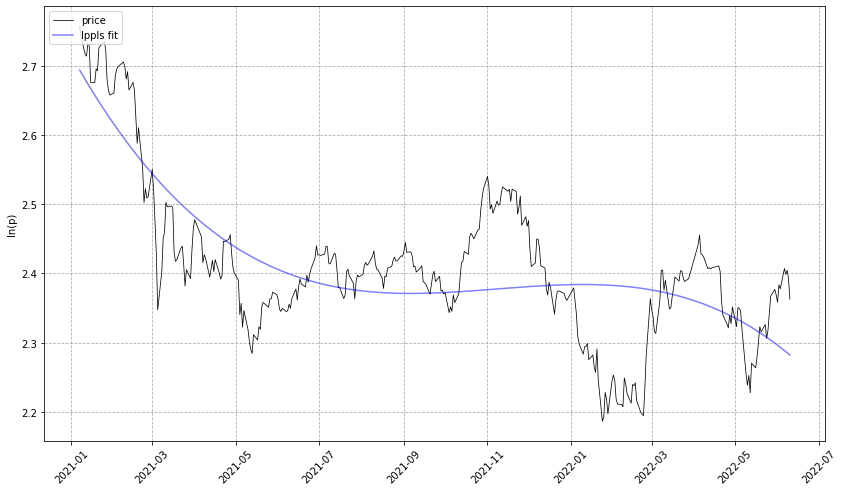

In [25]:
#Korelacja między cenami zaknięcia, a oszacowaniami LPPL
lppls_model.plot_fit()

Na jego podstawie można określić jakość dopasowania.

100%|██████████| 246/246 [02:37<00:00,  1.56it/s]


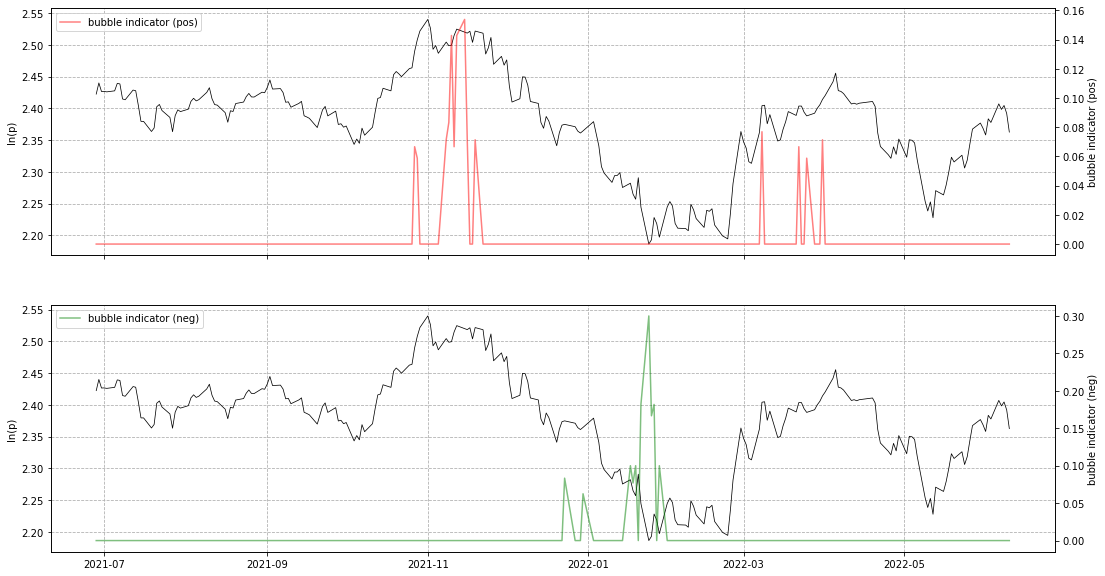

In [26]:
# Wskaźnik występowania bąbli

res = lppls_model.mp_compute_nested_fits(
    workers=8,
    window_size=120, 
    smallest_window_size=30, 
    outer_increment=1, 
    inner_increment=5, 
    max_searches=25,
    # filter_conditions_config={} # not implemented in 0.6.x
)

lppls_model.plot_confidence_indicators(res)

Opierając się na powyższym wykresie jesteśmy w stanie określić momenty występowania pozytywnych, jak i negatywnych bąbli na danym aktywie. Może to być istotne, gdy chcemy skojarzyć występowanie bąbli z jakimiś wydarzeniami mającymi, w danym momencie, miejsce na świecie.

###### Daty występowania bąbli.

In [27]:
# Bąble pozytywne

res_df = lppls_model.compute_indicators(res)
res_df['date'] = [pd.Timestamp.fromordinal(int(t1)) for t1 in res_df['time']]
res_df.loc[res_df['pos_conf'] >0][['date','pos_conf']]

,date,pos_conf
87,2021-10-27,0.066667
88,2021-10-28,0.058824
95,2021-11-08,0.071429
96,2021-11-09,0.083333
97,2021-11-10,0.142857
98,2021-11-11,0.066667
99,2021-11-12,0.142857
100,2021-11-15,0.153846
101,2021-11-16,0.071429
104,2021-11-19,0.071429


In [28]:
# Bąble negatywne

res_df = lppls_model.compute_indicators(res)
res_df['date'] = [pd.Timestamp.fromordinal(int(t1)) for t1 in res_df['time']]
res_df.loc[res_df['neg_conf'] >0][['date','neg_conf']]

,date,neg_conf
128,2021-12-23,0.083333
132,2021-12-30,0.062500
143,2022-01-17,0.100000
144,2022-01-18,0.076923
145,2022-01-19,0.100000
147,2022-01-21,0.181818
148,2022-01-24,0.300000
149,2022-01-25,0.166667
150,2022-01-26,0.181818
152,2022-01-28,0.100000


In [29]:
# Pobranie dat w formacie csv w obecnej lokalizacji 

res_df.loc[res_df['pos_conf'] >0][['date','neg_conf']].to_csv('pos_bubbles')
res_df.loc[res_df['neg_conf'] >0][['date','neg_conf']].to_csv('neg_bubbles')

## 4. XGBoost - algorytm oparty na uczeniu maszynowym

Algorytm uczenia maszynowego oparty na drzewach decyzyjnych, wykorzystujący technikę boostowania gradientu. 

In [30]:
# Dodanie opóźnionych cen zamknięcia do zbioru

for x in range(3):
    data['close_t-'+ str(x+1)] = data['close'].shift(x+1)

In [31]:
# Usunięcie daty ze zbioru regresorów

catFeatures = []
Features = data.columns.tolist()
Features.remove('close')
numFeatures = [x for x in Features if x not in catFeatures]
numFeatures.remove('date')

In [32]:
# Zdefiniowanie funkcji WMAPE - określających błędy predycji

def wmape_func(df, actual, forecast):
    abs_numerator = abs(df[actual] - df[forecast])
    denominator = df[actual].sum()
    numerator = abs_numerator.sum()
    wmape = numerator / denominator * 100
    return wmape


###  Podział na zbiór treningowy i testowy

In [86]:
# Zbiór treningowy i testowy wraz z ustalenie długości zbioru testowego

day_ordinal = datetime.now() - timedelta(days=100)
day = day_ordinal.strftime('%Y-%m-%d')

test = data[(data['date'] > day)]
train = data[(data['date'] <= day)]

In [87]:
# Pokaż liczbę obserwacji w każdym zbiorze
udzial_test=round(len(list(test['close']))/(len(list(test['close']))+len(list(train['close'])))*100)
udzial_train=round(len(list(train['close']))/(len(list(test['close']))+len(list(train['close'])))*100)
print("Liczba obserwacji w zbiorze testowym wynosi", len(list(test['close'])), ", co stanowi około ",udzial_test,"% całości.")
print("Liczba obserwacji w zbiorze treningowym wynosi", len(list(train['close'])),", co stanowi około",udzial_train, "% całości.")

Liczba obserwacji w zbiorze testowym wynosi 68 , co stanowi około  19 % całości.
Liczba obserwacji w zbiorze treningowym wynosi 297 , co stanowi około 81 % całości.


In [ ]:
# Uzupełnij braki (NaN) poprzednią dostępną wartością ( w większości przypadków NaN występuje z powodu weekendu lub świąt).
# W przypadku braku wartości wcześniejszej wstawiam średnią.

for column in data:
    for x in range(10):
        test[column] = test[column].fillna(test[column].shift(x))
        train[column] = train[column].fillna(train[column].shift(x))
        
train = train.fillna(train.mean())
test = test.fillna(test.mean())

#### Pierwsza estymacja Random Forest

In [89]:
# Random Forest
train['date'] = pd.to_datetime(train['date'],infer_datetime_format=True)
train['date'] = train['date'].apply(lambda x: x.toordinal())

test['date'] = pd.to_datetime(test['date'],infer_datetime_format=True)
test['date'] = test['date'].apply(lambda x: x.toordinal())

xtr, xts = train.drop(['close'], axis=1), test.drop(['close'], axis=1)
ytr, yts = train['close'].values, test['close'].values

RF = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=2022)
RF.fit(xtr, ytr)

test['pred'] = RF.predict(xts)
train['pred'] = RF.predict(xtr)


In [90]:
# Drukuję błędy WMAPE
print(wmape_func(train, 'close', 'pred'))
print(wmape_func(test, 'close', 'pred'))

0.6468346517339703
1.8009476628510515


#### Dobieram hiperparametry.

In [91]:
#Number of estimators

for k in [10, 25, 50, 100, 200, 500, 1000]:
    RF = RandomForestRegressor(n_estimators=k, n_jobs=-1, random_state=2022)
    RF.fit(xtr, ytr)

    test['pred'] = RF.predict(xts)
    train['pred'] = RF.predict(xtr)
    
    print(k, " train wmape: ", wmape_func(train, 'close', 'pred'))
    print(k, " test wmape: ", wmape_func(test, 'close', 'pred'))


10  train wmape:  0.6890791805839973
10  test wmape:  1.7479498875220725
25  train wmape:  0.6526477689647042
25  test wmape:  1.7829832714140157
50  train wmape:  0.6601380567500744
50  test wmape:  1.7558281818395545
100  train wmape:  0.6570563163069638
100  test wmape:  1.7407670621483806
200  train wmape:  0.6511215850002047
200  test wmape:  1.7502181117810889
500  train wmape:  0.646193233166181
500  test wmape:  1.7914870729882224
1000  train wmape:  0.646834651733969
1000  test wmape:  1.8009476628510526


In [92]:
#Max depth

for k in range(2,30,2):
    RF = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=2022,  max_depth=k)
    RF.fit(xtr, ytr)

    test['pred'] = RF.predict(xts)
    train['pred'] = RF.predict(xtr)
    
    print(k, " train wmape: ", wmape_func(train, 'close', 'pred'))
    print(k, " test wmape: ", wmape_func(test, 'close', 'pred'))

2  train wmape:  2.990697609536214
2  test wmape:  2.5722647376913863
4  train wmape:  1.37429732272887
4  test wmape:  1.6816222440906397
6  train wmape:  1.0192387858367993
6  test wmape:  1.6302094106324903
8  train wmape:  0.8274855149968344
8  test wmape:  1.7501061441437038
10  train wmape:  0.7155721483655685
10  test wmape:  1.7472719497014029
12  train wmape:  0.6705953452356578
12  test wmape:  1.7491488622609481
14  train wmape:  0.6574288857100019
14  test wmape:  1.7381405911174947
16  train wmape:  0.6568836638967934
16  test wmape:  1.7393896434273768
18  train wmape:  0.6574811821647136
18  test wmape:  1.7405126560138742
20  train wmape:  0.6570563163069648
20  test wmape:  1.7407670621483815
22  train wmape:  0.6570563163069646
22  test wmape:  1.7407670621483777
24  train wmape:  0.6570563163069647
24  test wmape:  1.740767062148382
26  train wmape:  0.6570563163069638
26  test wmape:  1.740767062148377
28  train wmape:  0.657056316306964
28  test wmape:  1.740767062

In [93]:
#The minimum number of samples

for k in [2, 4, 6, 8,20, 40]:
    RF = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=2022,  max_depth=10, 
                                min_samples_split=k)
    RF.fit(xtr, ytr)

    test['pred'] = RF.predict(xts)
    train['pred'] = RF.predict(xtr)
    
    print(k, " train wmape: ", wmape_func(train, 'close', 'pred'))
    print(k, " test wmape: ", wmape_func(test, 'close', 'pred'))

2  train wmape:  0.7150423007064557
2  test wmape:  1.7425787095853174
4  train wmape:  0.7657654520236101
4  test wmape:  1.759874340718512
6  train wmape:  0.853695918911467
6  test wmape:  1.7411560816529563
8  train wmape:  0.9402862114276542
8  test wmape:  1.7256984999300753
20  train wmape:  1.3739485981398543
20  test wmape:  1.6881331385114753
40  train wmape:  1.764838322457657
40  test wmape:  1.7778390887287583


#### Ostateczne wyniki

In [94]:
RF = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=2022,  max_depth=10, 
                                min_samples_split=8)
RF.fit(xtr, ytr)

test['pred'] = RF.predict(xts)
train['pred'] = RF.predict(xtr)

In [95]:
# Drukuję błędy WMAPE
print(wmape_func(train, 'close', 'pred'))
print(wmape_func(test, 'close', 'pred'))

0.9402862114276531
1.7256984999300733


In [96]:
# Przywracam klasyczny format daty
test['date'] = test['date'].apply(datetime.fromordinal)
train['date'] = train['date'].apply(datetime.fromordinal)


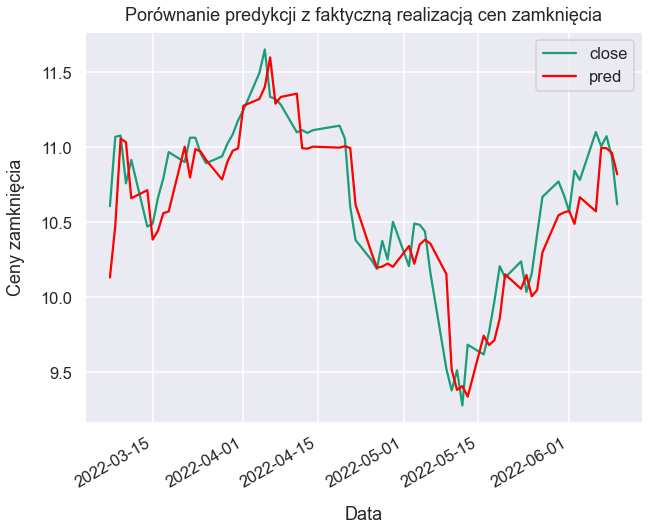

In [97]:
# Graficzne porównanie rzeczywistych cen zamknięcia wraz z predykcjami

ax = plt.gca()

test.plot(kind='line',x='date',y='close',ax=ax, figsize=(10,8))
test.plot(kind='line',x='date',y='pred', color='red', ax=ax, figsize=(10,8))
plt.xlabel("Data", labelpad=15)
plt.ylabel("Ceny zamknięcia", labelpad=15)
plt.title('Porównanie predykcji z faktyczną realizacją cen zamknięcia', y=1.012, fontsize=18)

plt.show()

Powyższy wykres pozwala określić jak blisko dopasowania do rzeczywistej ceny wybranego aktywa jesteśmy w naszych predykcjach. 

## 5. Analiza sentymentu - Reddit

Analiza sentymentu – metoda analizy tekstu. Jej zadaniem jest wyszukać i zaklasyfikować w wypowiedzi słowa naznaczone emocjonalnie: zarówno takie, które świadczą o stanie emocjonalnym autora jak i te, które mogą wskazywać na efekt emocjonalny, jaki wypowiedź uzyska u odbiorcy. <br>
Wykorzystywana w kontekście badania nastrojów społecznych wokół danego zjawiska.

In [45]:
sns.set(style='darkgrid', context='talk', palette='Dark2')

In [46]:
#Uwierzytelnienie
reddit = praw.Reddit(client_id='OfdQYZaaCoX0mic4Cvt64g',
                     client_secret='YPJcjSL9fwgj7tz3IHfYikwoGf4sQA',
                     user_agent='kuba1t1fcb')

In [47]:
headlines = set()

In [48]:
# Pobieranie postów
for submission in reddit.subreddit('cleanenergy').new(limit=100):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

100


In [49]:
# Określam sentyment

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

In [50]:
#Tworzę data frame z danymi
df = pd.DataFrame.from_records(results)

In [51]:
#Określam dany post jako pozytywny, neutralny lub negatywny (mając na względzie słowo kluczowe można pomanipulować wartościami
#od których uznaje się dany post za pozytywny, bądź też negatywny).
df['label'] = 0
df.loc[df['compound'] > 0.6, 'label'] = 1
df.loc[df['compound'] < -0.3, 'label'] = -1

In [52]:
#Zapis do formatu csv w bieżącej lokalizacji
df2 = df[['headline', 'label']]
df2.to_csv('reddit_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

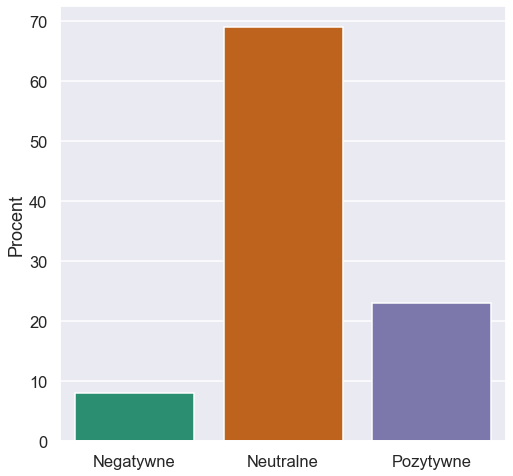

In [55]:
# Tworzę wykres porównawczy postu pozytywne, neutralne i negatywne

fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negatywne', 'Neutralne', 'Pozytywne'])
ax.set_ylabel("Procent")

plt.show()

#### Tokenizers and Stopwords

W kolejnym kroku każdy post zostanie stokenizowany. Dodatkowo usunięte zostaną tzw. stopwordy.

In [56]:
tokenizer = RegexpTokenizer(r'\w+')

In [57]:
stop_words = stopwords.words('english')

In [58]:
# Definiuję funkcję odpowiedzialną za tokenizację oraz oczyszczenie ze stopwordów.

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

###### Słowa pozytywne

In [99]:
# Tworzę listę najczęściej występujących słów pozytywnych

pos_lines = list(df[df.label == 1].headline)
pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

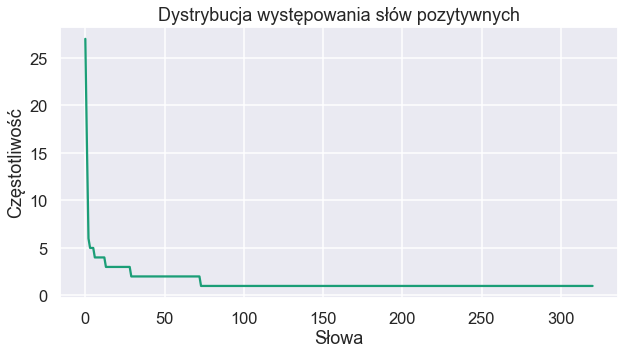

In [60]:
# Wykres rozkładu słów pozytywnych (na postawie listy stworzonej w poprzedniej komórce)

y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Słowa")
plt.ylabel("Częstotliwość")
plt.title("Dystrybucja występowania słów pozytywnych")
plt.show()

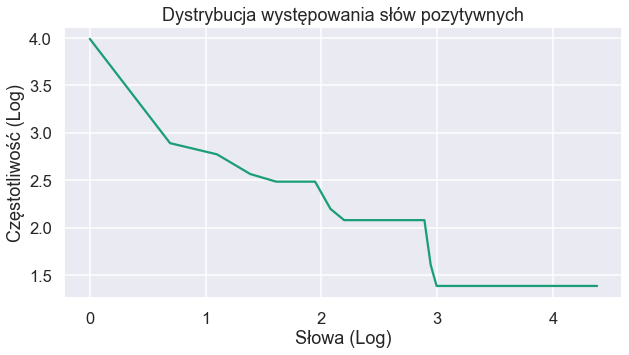

In [61]:
# Wykres rozkładu słów pozytywnych (zlogarytmowany)

y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Słowa (Log)")
plt.ylabel("Częstotliwość (Log)")
plt.title("Dystrybucja występowania słów pozytywnych")
plt.plot(x_val, y_final)
plt.show()

###### Słowa negatywne

In [62]:
# Tworzę listę najczęściej występujących słów negatywnych

neg_lines = list(df2[df2.label == -1].headline)
neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

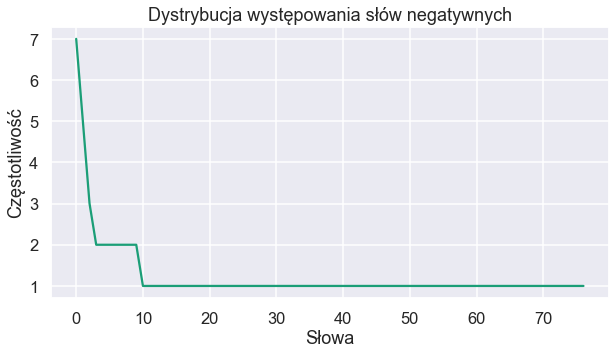

In [63]:
# Wykres rozkładu słów negatywnych (na postawie listy stworzonej w poprzedniej komórce)

y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Słowa")
plt.ylabel("Częstotliwość")
plt.title("Dystrybucja występowania słów negatywnych")
plt.show()

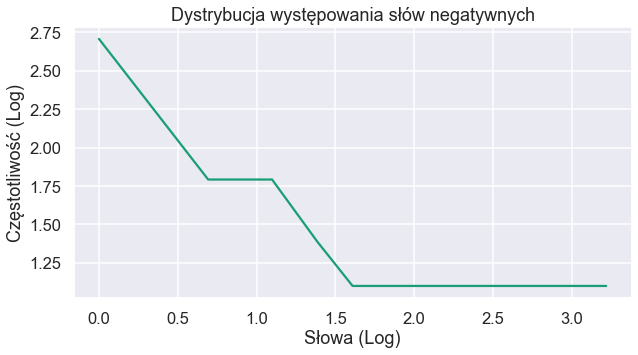

In [64]:
# Wykres rozkładu słów negatywnych (zlogarytmowany)

y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Słowa (Log)")
plt.ylabel("Częstotliwość (Log)")
plt.title("Dystrybucja występowania słów negatywnych")
plt.plot(x_val, y_final)
plt.show()

### Podsumowanie 

Powyższy kod może stanowić przydatne narzędzie w procesie dokonywania decyzji inwestycyjnych. Naturalnie w przypadku analizowania różnego typu aktywów powinno się zwracać uwagę na różnego typu akcenty. Na przykład, w sytuacji, gdy badanie poddawana jest spółka z branży metalurgicznej analiza sentymentu nie wydaje się być tak istotna jak w przypadku lokowania środów chociażby w kryptowaluty, gdzie wartość fundamentalna tychże wynosi nic, a ich finalna cena oparta jest głównie na emocjach uczestników rynku. Co za tym idzie warto każdorazowo przypisać każdemu z narzędzi adekwatną wagę, naturalnie do wybranego aktywa, z jaką dany wynik będzie miał wpływ na finalną decyzję.  <br>


### Źródła:
https://albertrtk.github.io/2020/11/07/Downloading-stock-market-quotes-from-Stooq.html <br>
https://hackernoon.com/how-to-use-google-trends-api-with-python <br>
https://pypi.org/project/lppls/ <br>
https://www.datacamp.com/tutorial/xgboost-in-python <br>
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/ <br>
https://stooq.pl/ <br>
https://trends.google.pl/trends/ <br>